**Intro & Setup**

We are going to graph and analyze our EPM data. Start by setting the directory to the folder containing the AE masterdoc spreadsheet. The following cells will import relevant packages.

In [1]:
setwd("/Users/rida/Desktop/BU/Meyer Lab/EPM")

In [2]:
#only need to install once
#install.packages("ggpubr")
#install.packages('FSA')

In [9]:
library(readxl); #read Excel data into R
library(writexl);#export data frames in R into Excel
library(ggplot2); #make various graphs
library(forcats); #allows for manipulation of factors (Categorical variables)
library(ggsci); #color palettes for ggplot2
library(patchwork); #combine multiple ggplots into one graphic
library(ez); #factorial experiment analysis and visualization
library(rstatix); #basic statistical tests (t-test, ANOVA, etc)
library(multcomp); #simultaneous inference in linear models
library(tidyverse) #collection of R packages for data manipulation and visualization, includes %>% (pipe operator from magrittr package)
library(ggpubr)
library(egg) #for ggarrange
library(FSA) #for peek, head

Convert the spreadsheet to long format and include the specified columns.

In [4]:
EPM <- read_xlsx(sheet = 1, 'AE masterdoc.xlsx')

EPM_long <- EPM %>%
  rstatix::select(MouseID, Condition:c("Time spent in open arms")) %>%
  pivot_longer(cols = c("Freeze (first 2 min)"):c("Time spent in open arms"), names_to = "Behavior", values_to = "Response")

A brief look at the data we extracted:

In [5]:
head(EPM_long,9)

MouseID,Condition,Age,Sex,Behavior,Response
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
AE1-1,Safety,Adolescent,Male,Freeze (first 2 min),11.84
AE1-1,Safety,Adolescent,Male,Latency to middle (time stamp),6.05
AE1-1,Safety,Adolescent,Male,Time spent in open arms,6.05
AE1-3,Safety,Adolescent,Male,Freeze (first 2 min),15.60
AE1-3,Safety,Adolescent,Male,Latency to middle (time stamp),29.22
AE1-3,Safety,Adolescent,Male,Time spent in open arms,33.32
AE1-4,Safety,Adolescent,Male,Freeze (first 2 min),6.61
AE1-4,Safety,Adolescent,Male,Latency to middle (time stamp),20.56
AE1-4,Safety,Adolescent,Male,Time spent in open arms,30.81


Define a function fig_stats to calculate mean, standard deviation, sample size, and standard error of mean.

In [6]:
fig_stats <- function(x) 
{x %>% summarize(mean = mean(Response),
                 sd   = sd(Response),
                 n    = n(),
                 sem  = sd / sqrt(n))}

We are recording 3 things: 
- Time freezing in the first two mintues (in seconds)
- Latency to the middle (in seconds)
- Time spent in open arms (in seconds)

There are 3 independent variables that we are also recording:
- Condition (Homecage, Safety, Yoked Fear)
- Sex (Female, Male)
- Age (Adolescent, Adult)

This means that there are 12 possible combinations of conditions to record from and 3 things to record. Let us quickly visualize what this data would look like:

`summarise()` has grouped output by 'Behavior', 'Condition', 'Sex'. You can
override using the `.groups` argument.


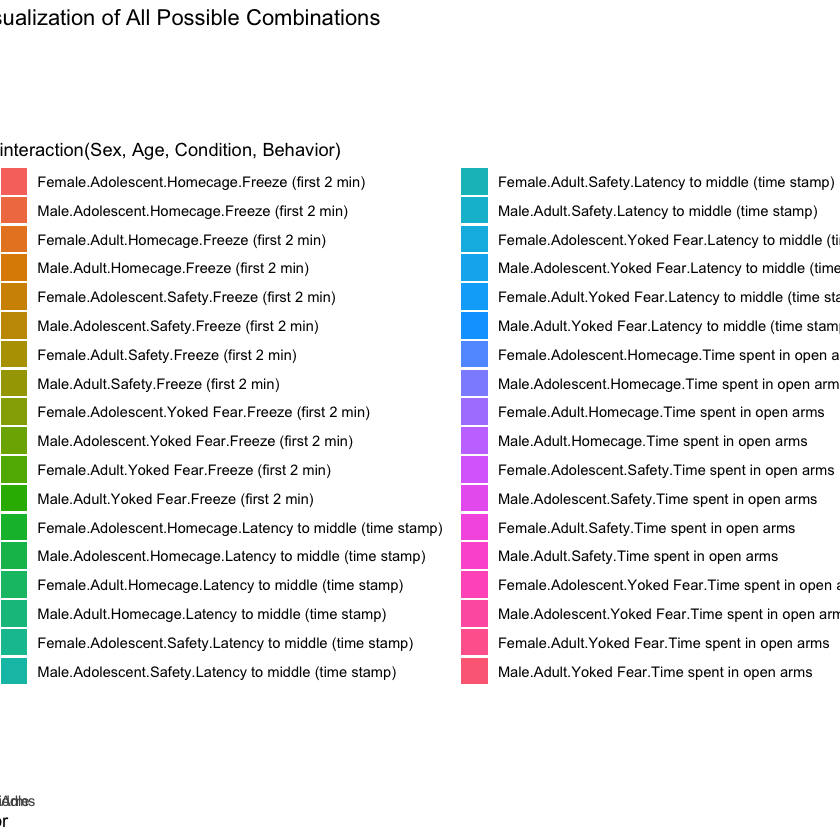

In [10]:
EPM_all <- EPM_long %>%
  filter(!is.na(Response)) %>%
  group_by(Behavior, Condition, Sex, Age) %>% 
  fig_stats

p_visual <- ggplot(EPM_all, aes(x = Behavior, y = mean, fill = interaction(Sex,Age,Condition,Behavior))) + 
  geom_col(position = position_dodge2(width = 0.7)) +
  ggtitle("Visualization of All Possible Combinations") +
  geom_errorbar(aes(ymin = mean - sem, ymax = mean + sem), width = .3, size = .1, color = "#75797c", 
                position = position_dodge(width = 0.9)) + 
  scale_x_discrete(name="Behavior", labels = c("Freezing", "Latency to Middle", "Time in Open Arms")) + 
  scale_y_continuous("Average Time (seconds)", breaks= seq(0, 200,20)) +
  theme_classic()

p_visual

This graph is too large to be shown here so here is a screenshot of what it would look like:

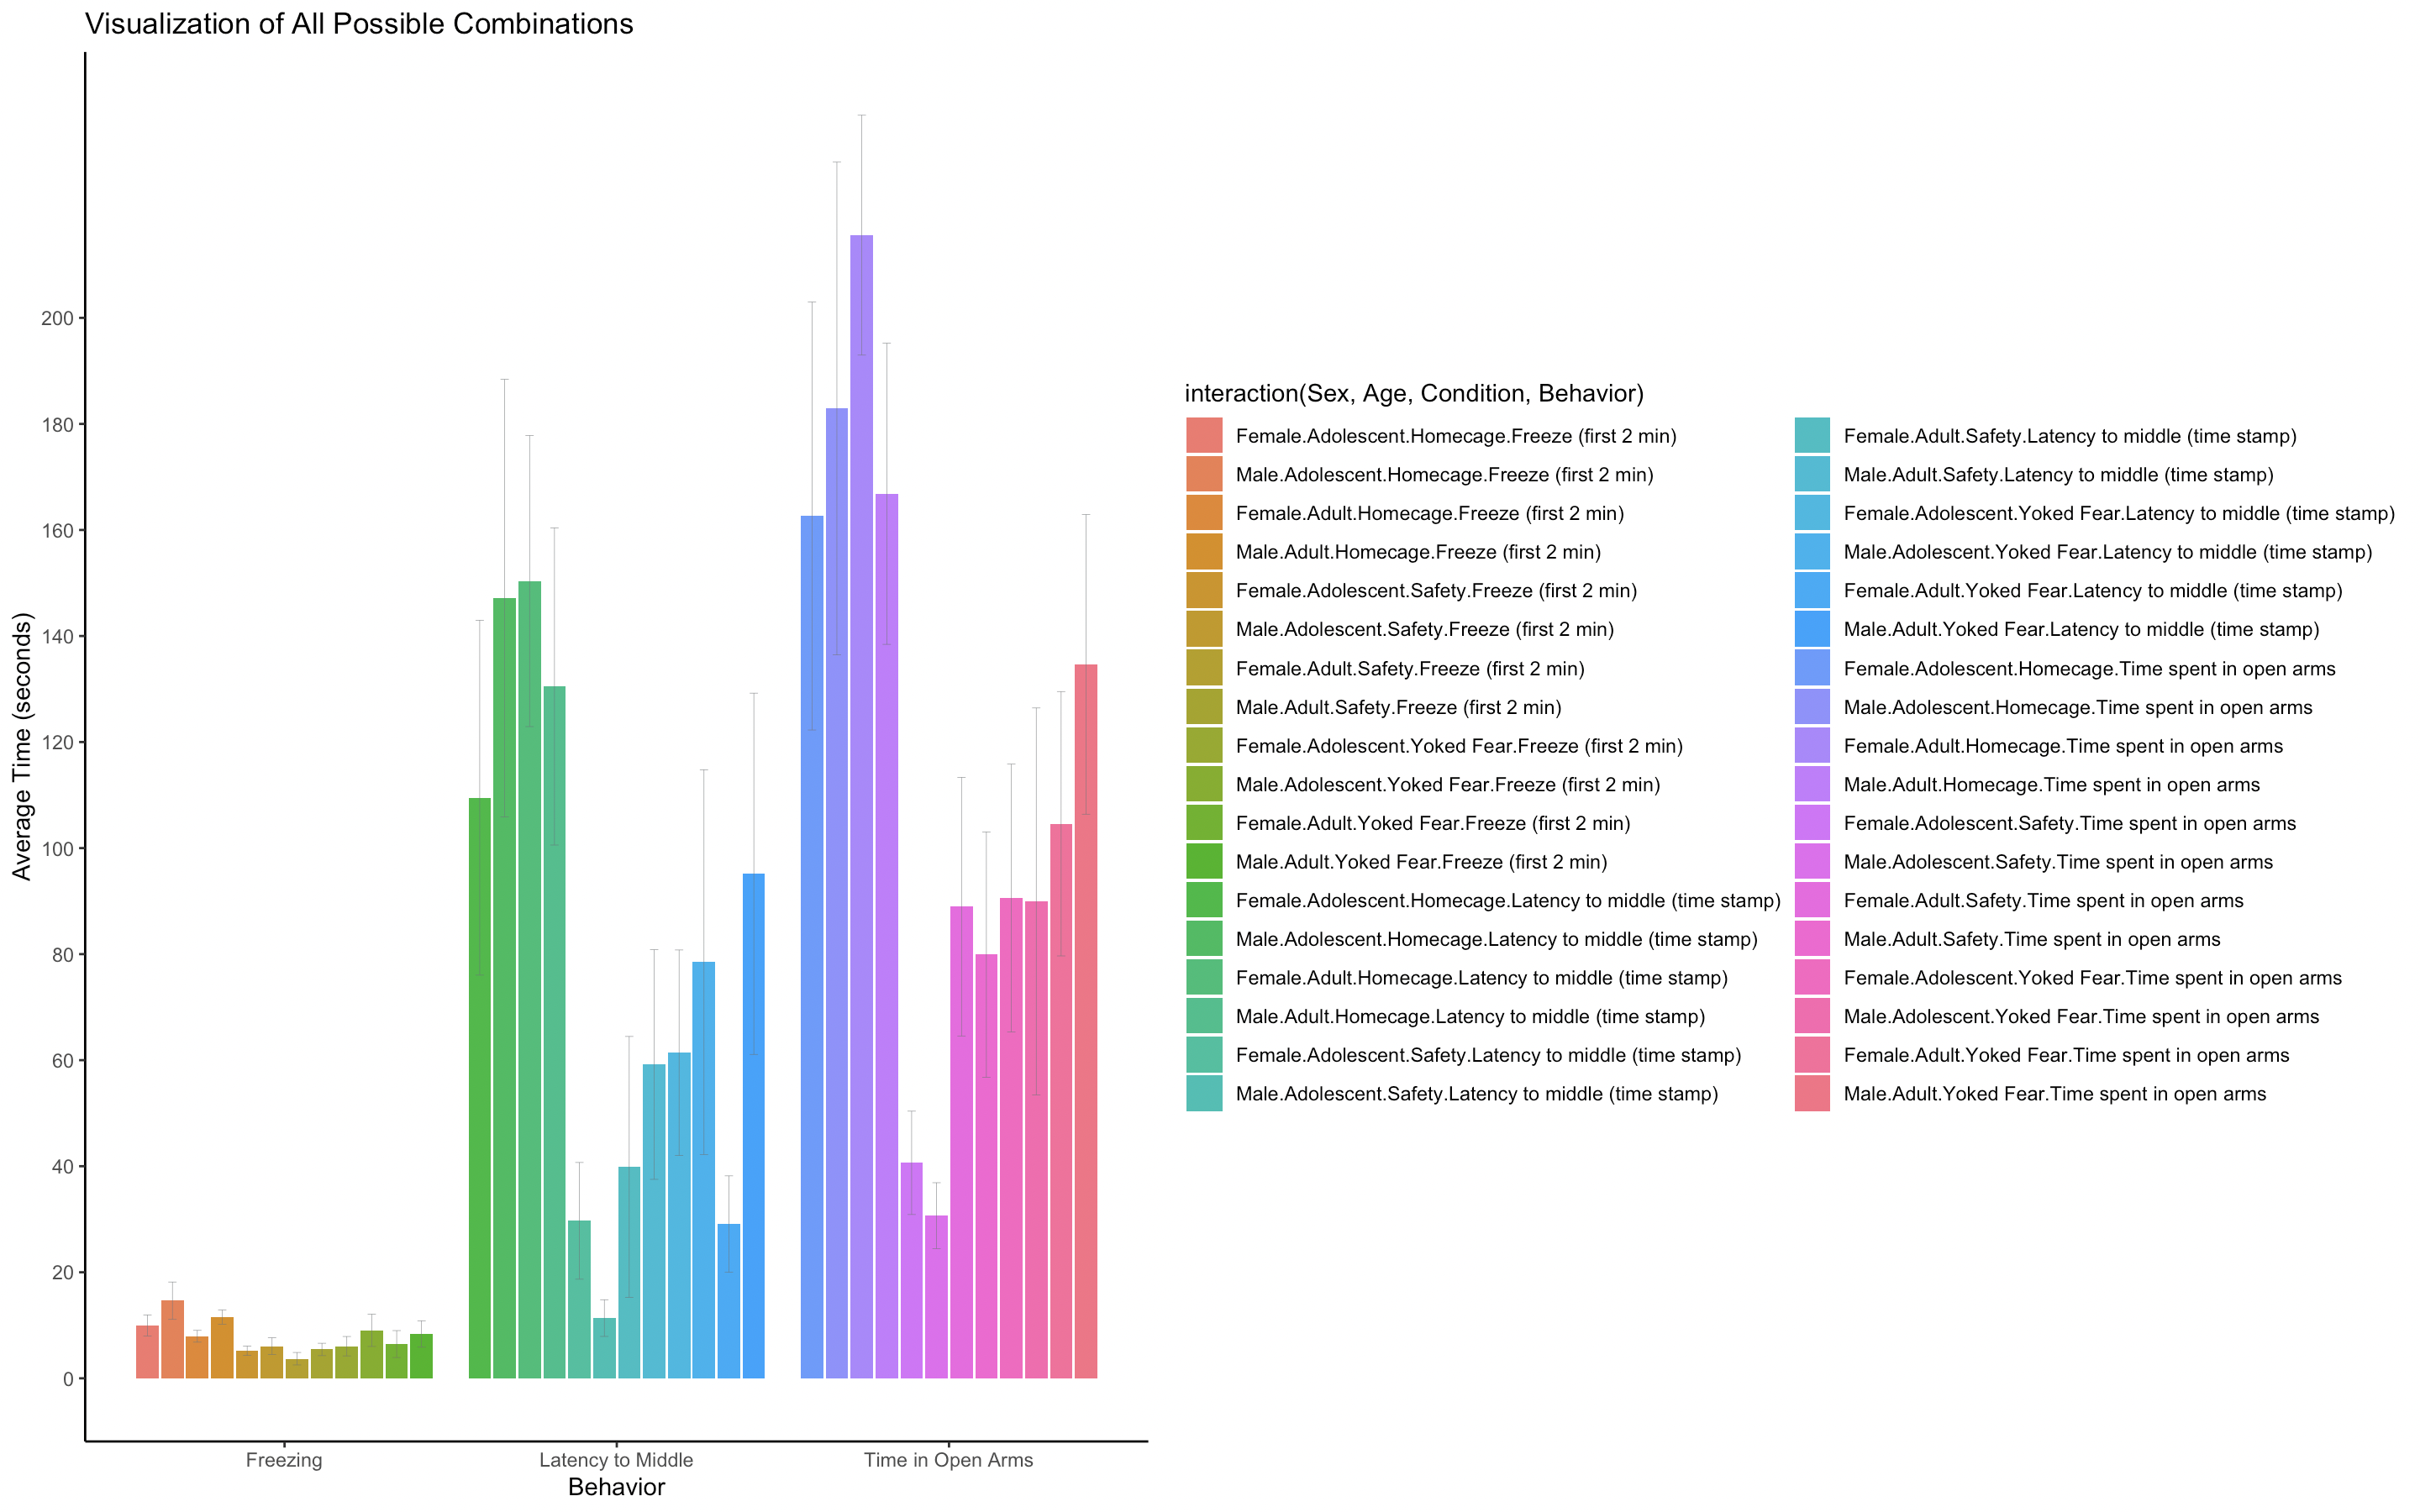

**Statistical Analysis**

Let's run some statistical tests to see which of these interactions is actually significant. Starting with the freezing data, we can run an ANOVA to determine which variables affect freezing in a meaninful way.

In [8]:
EPM_freezing <- EPM_long %>%
  filter(!is.na(Response), Behavior == "Freeze (first 2 min)")

EPM_freezing_model <- anova_test(data = EPM_freezing, dv = Response, wid = MouseID, between = c(Condition, Age, Sex), effect.size = "pes")
EPM_freezing_model

,Effect,DFn,DFd,F,p,p<.05,pes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Condition,2,106,10.713,5.79e-05,*,0.168000
2,Age,1,106,1.305,2.56e-01,,0.012000
3,Sex,1,106,5.765,1.80e-02,*,0.052000
4,Condition:Age,2,106,0.421,6.57e-01,,0.008000
5,Condition:Sex,2,106,0.612,5.44e-01,,0.011000
6,Age:Sex,1,106,0.036,8.50e-01,,0.000337
7,Condition:Age:Sex,2,106,0.086,9.18e-01,,0.002000


The ANOVA tells us that Condition and Sex are significant. Let's run a t-test for both of them to further evaluate that significance.

In [11]:
#t-test: condition
EPM_freezing_Posthoc_T_Condition <- EPM_freezing %>% t_test(Response ~ Condition, var.equal = TRUE, paired = FALSE)
EPM_freezing_Posthoc_T_Condition

,.y.,group1,group2,n1,n2,statistic,df,p,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Response,Homecage,Safety,48,38,4.814216,84,6.45e-06,1.94e-05,****
2,Response,Homecage,Yoked Fear,48,32,2.122317,78,3.70e-02,7.40e-02,ns
3,Response,Safety,Yoked Fear,38,32,-1.874058,68,6.50e-02,7.40e-02,ns


In [12]:
#t-test: sex
EPM_freezing_Posthoc_T_Sex <- EPM_freezing %>% t_test(Response ~ Sex, var.equal = TRUE, paired = FALSE)
EPM_freezing_Posthoc_T_Sex

,.y.,group1,group2,n1,n2,statistic,df,p
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,Response,Female,Male,59,59,-2.547599,116,0.0122


From these t-tests, we can see that there is a difference in female and male behavior in freezing (t-statistic = -2.47, so females froze less than males), and there is a significant difference in the bahvior of homecage versus safety mice.

Now, let's run another ANOVA to look for significant variables for latency to the middle.

In [15]:
EPM_latency <- EPM_long %>%
  filter(!is.na(Response), Behavior == "Latency to middle (time stamp)")

EPM_latency_model <- anova_test(data = EPM_latency, dv = Response, wid = MouseID, between = c(Condition, Age, Sex), effect.size = "pes")
EPM_latency_model

,Effect,DFn,DFd,F,p,p<.05,pes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Condition,2,106,13.416,6.40e-06,*,0.202000
2,Age,1,106,0.439,5.09e-01,,0.004000
3,Sex,1,106,1.029,3.13e-01,,0.010000
4,Condition:Age,2,106,0.378,6.86e-01,,0.007000
5,Condition:Sex,2,106,0.517,5.98e-01,,0.010000
6,Age:Sex,1,106,0.084,7.73e-01,,0.000791
7,Condition:Age:Sex,2,106,1.080,3.43e-01,,0.020000


The ANOVA says that condition is once again significant, so let's run a t-test to further explore that significance.

In [16]:
EPM_latency_Posthoc_T_Condition <- EPM_latency %>% t_test(Response ~ Condition, var.equal = TRUE, paired = FALSE)
EPM_latency_Posthoc_T_Condition

,.y.,group1,group2,n1,n2,statistic,df,p,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Response,Homecage,Safety,48,38,5.165092,84,1.59e-06,4.77e-06,****
2,Response,Homecage,Yoked Fear,48,32,3.118155,78,3.00e-03,5.00e-03,**
3,Response,Safety,Yoked Fear,38,32,-1.965233,68,5.40e-02,5.40e-02,ns


From this t-test, we can see that the difference in homecage versus safety and homecage versus yoked fear is sificant. There is no significant difference in latency to the middle between the safety and yolked fear mice.

Finally, let's look for what is significant for time spent in the open arms.

In [17]:
EPM_openarms <- EPM_long %>%
  filter(!is.na(Response), Behavior == "Time spent in open arms")

EPM_openarms_model <- anova_test(data = EPM_openarms, dv = Response, wid = MouseID, between = c(Condition, Age, Sex), effect.size = "pes")
EPM_openarms_model

,Effect,DFn,DFd,F,p,p<.05,pes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Condition,2,106,19.558,5.89e-08,*,0.270000
2,Age,1,106,3.664,5.80e-02,,0.033000
3,Sex,1,106,0.032,8.58e-01,,0.000302
4,Condition:Age,2,106,0.298,7.43e-01,,0.006000
5,Condition:Sex,2,106,0.268,7.66e-01,,0.005000
6,Age:Sex,1,106,0.138,7.11e-01,,0.001000
7,Condition:Age:Sex,2,106,0.798,4.53e-01,,0.015000


Once again, condiition is significant and we will run a t-test accordingly.

In [18]:
EPM_openarms_Posthoc_T_Condition <- EPM_openarms %>% t_test(Response ~ Condition, var.equal = TRUE, paired = FALSE)
EPM_openarms_Posthoc_T_Condition

,.y.,group1,group2,n1,n2,statistic,df,p,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Response,Homecage,Safety,48,38,6.290078,84,1.37e-08,4.11e-08,****
2,Response,Homecage,Yoked Fear,48,32,3.504702,78,7.61e-04,2.00e-03,**
3,Response,Safety,Yoked Fear,38,32,-2.682883,68,9.00e-03,9.00e-03,**


There is a significant difference in the amount of time spent in the open arms of the elevated plus maze between each of the 3 conditions.

Now that we know this, let's start visualizing the data in a more clean way where we can see these comparisons.

In [19]:
EPM_group_s_a <- EPM_long %>% 
  unite(Group, c(Sex, Age), sep = " ", remove = FALSE)

#freezing
EPM_freezing_s_a <- EPM_group_s_a %>%
  filter(!is.na(Response), Behavior == "Freeze (first 2 min)") %>%
  group_by(Group, Condition) %>% 
  fig_stats

#latency to middle
EPM_latency_s_a <- EPM_group_s_a %>%
  filter(!is.na(Response), Behavior == "Latency to middle (time stamp)") %>%
  group_by(Group, Condition) %>% 
  fig_stats

#time spent in open arms
EPM_openarms_s_a <- EPM_group_s_a %>%
  filter(!is.na(Response), Behavior == "Time spent in open arms") %>%
  group_by(Group, Condition) %>% 
  fig_stats

`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.


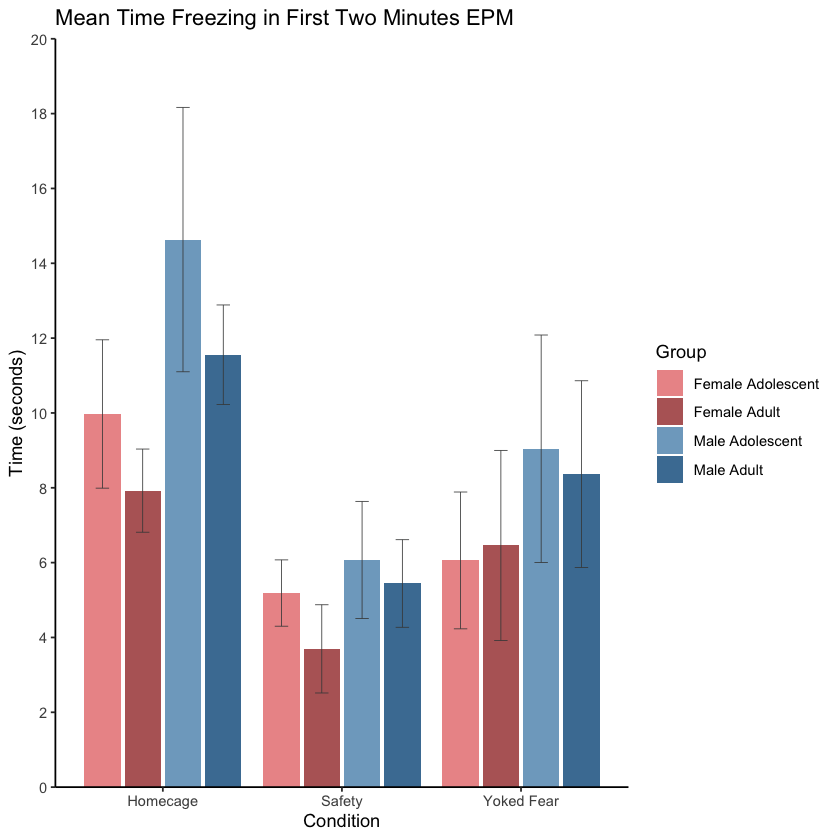

In [20]:
p_6 <- ggplot(EPM_freezing_s_a, aes(x = Condition, y = mean, fill = Group)) + 
  geom_col(position = position_dodge2(width = 0.7)) +
  ggtitle("Mean Time Freezing in First Two Minutes EPM") +
  scale_fill_manual(name = "Group",
                    values = c("#EC9797","#B66666", "#7FA9C7", "#4A7DA2")) + 
  geom_errorbar(aes(ymin = mean - sem, ymax = mean + sem), width = .3, size = .23, color = "#464747", 
                position = position_dodge(width = 0.9)) + 
  scale_y_continuous("Time (seconds)", breaks= seq(0,20,2),limits=c(0,20),expand = c(0, 0)) +
  theme_classic()

p_6

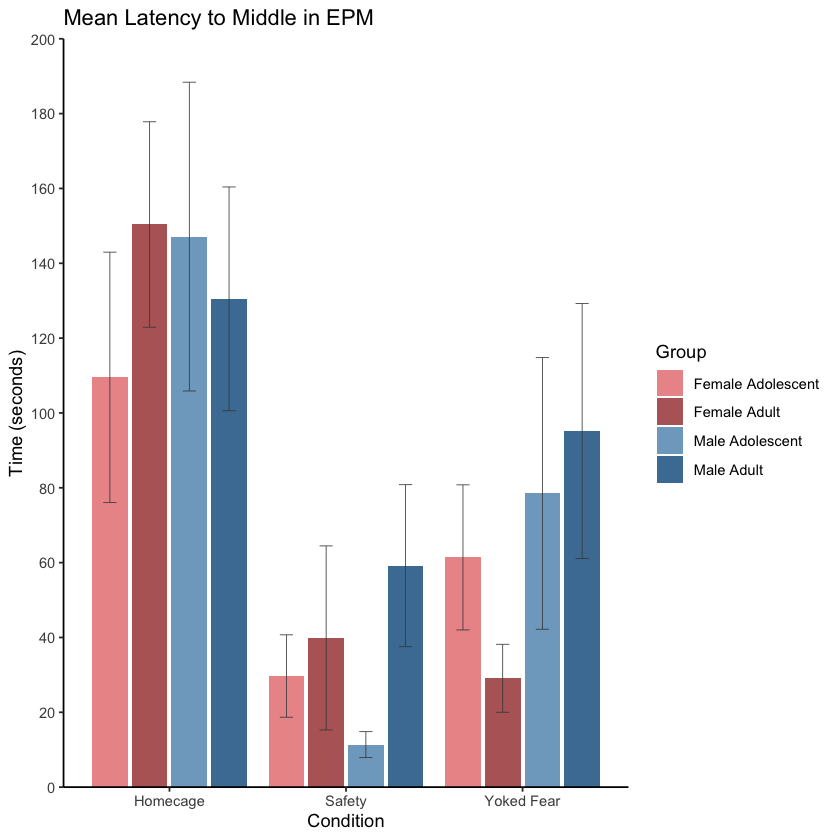

In [21]:
p_7 <- ggplot(EPM_latency_s_a, aes(x = Condition, y = mean, fill = Group)) + 
  geom_col(position = position_dodge2(width = 0.7)) +
  ggtitle("Mean Latency to Middle in EPM") +
  scale_fill_manual(name = "Group",
                    values = c("#EC9797","#B66666", "#7FA9C7", "#4A7DA2")) +
  geom_errorbar(aes(ymin = mean - sem, ymax = mean + sem), width = .3, size = .23, color = "#464747", 
                position = position_dodge(width = 0.9)) + 
  scale_y_continuous("Time (seconds)", breaks= seq(0,200,20),limits=c(0,200),expand = c(0, 0)) +
  theme_classic()

p_7

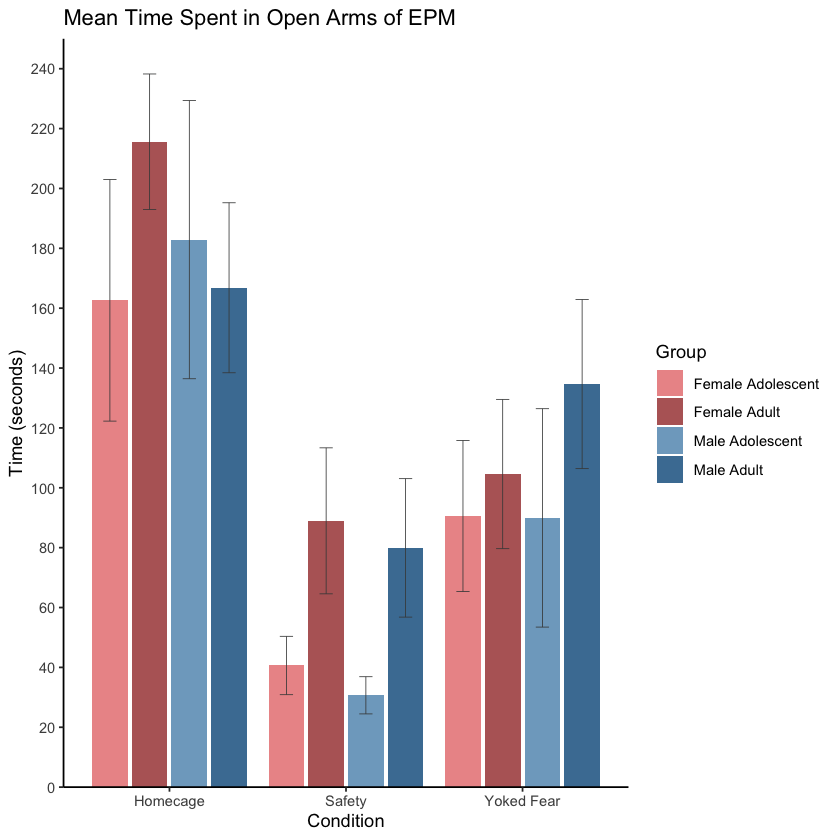

In [22]:
p_8 <- ggplot(EPM_openarms_s_a, aes(x = Condition, y = mean, fill = Group)) + 
  geom_col(position = position_dodge2(width = 0.7)) +
  ggtitle("Mean Time Spent in Open Arms of EPM") +
  scale_fill_manual(name = "Group",
                    values = c("#EC9797","#B66666", "#7FA9C7", "#4A7DA2")) + 
  geom_errorbar(aes(ymin = mean - sem, ymax = mean + sem), width = .3, size = .23, color = "#464747", 
                position = position_dodge(width = 0.9)) + 
  scale_y_continuous("Time (seconds)", breaks= seq(0,250,20),limits=c(0,250),expand = c(0, 0)) +
  theme_classic()

p_8

In [33]:
figure_s_a <- ggarrange(p_6,p_7,p_8, ncol = 1, nrow = 3,
                        common.legend = TRUE, legend="bottom")
figure_s_a

ERROR: Error in plot$plot_env: $ operator is invalid for atomic vectors


**Further visualization**

Let's explore different ways to visualize this data, such as heatmaps.

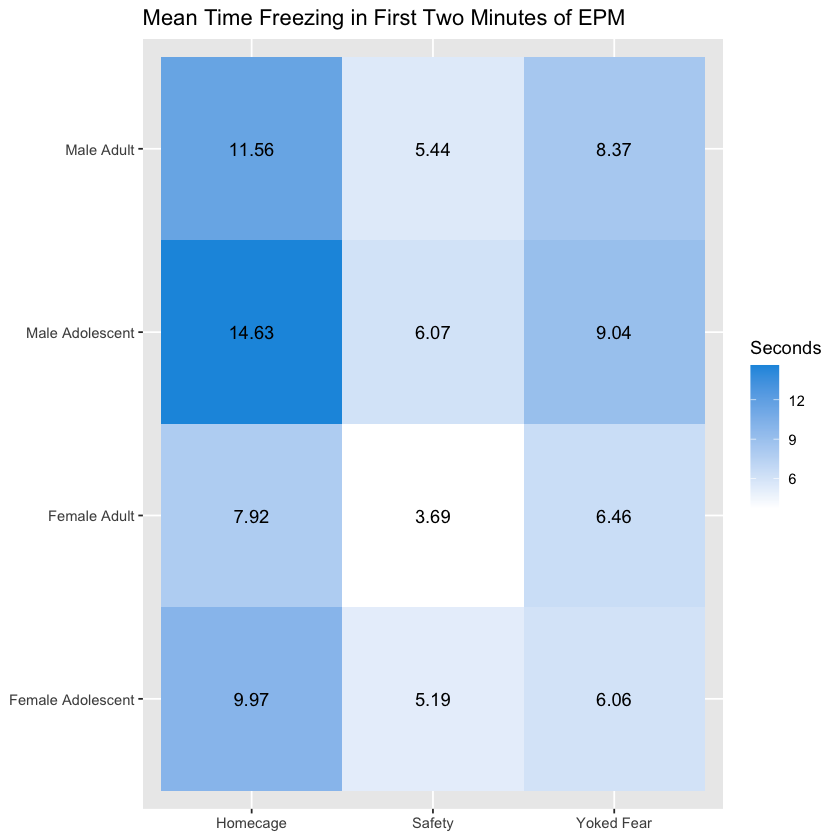

In [23]:
p_6a <- ggplot(EPM_freezing_s_a, aes(Condition,Group)) +
  geom_tile(aes(fill = mean)) +
  geom_text(aes(label = round(mean, 2))) +
  scale_fill_gradient(low = "white", high = "#1b98e0") +
  ggtitle("Mean Time Freezing in First Two Minutes of EPM") +
  ggplot2::theme(axis.title.x=element_blank()) +
  ggplot2::theme(axis.title.y=element_blank()) +
  labs(fill = "Seconds")

p_6a